In [ ]:
_ = """
+ CutMix 
+ data_aug

"""

In [ ]:
# traffic sign down
!gdown --id 1-MsSMJqE8AdMQYgS_tiYiaeTkiF4WB5F
!gdown --id 1ysKr2SJAxGWrdSvoA5fn40jhRQmbPswl
!unzip data.zip

In [ ]:
!ls

data.zip  sample_data  Test  Train


In [ ]:
# Few imports

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from PIL import Image

import pandas as pd

In [ ]:
# # https://pytorch.org/docs/stable/notes/randomness.html

# # REPRODUCIBILITY
# # Controlling sources of randomness

# RANDOM_SEED = 0

# torch.manual_seed(RANDOM_SEED)
# torch.cuda.manual_seed_all(RANDOM_SEED)

# random.seed(RANDOM_SEED)
# np.random.seed(RANDOM_SEED)

# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)



# # reduced performance
# # torch.backends.cudnn.deterministic = True # torch.use_deterministic_algorithms(True)
# # torch.backends.cudnn.benchmark = False

In [ ]:
# Before starting, clear the memory

torch.cuda.empty_cache()

In [ ]:
# Define the transformations. To begin with, we shall keep it minimum - only resizing the images and converting them to PyTorch tensors

data_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])

# # Define transformations

# test_transforms = transforms.Compose([
#     transforms.Resize([112, 112]),
#     transforms.ToTensor()
#     ])

In [ ]:
print(os.getcwd())
os.listdir()

/content


['.config', 'Train', 'Test', 'data.zip', 'sample_data']

In [ ]:
# Defining hyperparameters

BATCH_SIZE = 256
learning_rate = 0.001
EPOCHS = 15
numClasses = 43

In [ ]:
# Define path of training data

train_data_path = "./Train"
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

Number of training samples = 20808
Number of validation samples = 5202


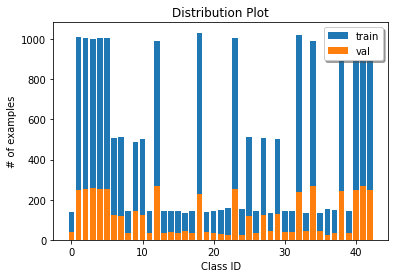

In [ ]:
# Plot histogram for training and validation data

train_hist = [0]*numClasses
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1
    
val_hist = [0]*numClasses
for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1

plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), val_hist, label="val")
legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [ ]:
# Create data loader for training and validation

# DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     worker_init_fn=seed_worker
# )

train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

In [ ]:
# Function to count the number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:

import torch.nn as nn

class AlexnetTS(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
            )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [ ]:
# Initialize the model
# The model is defined in the class AlexnetTS in the file class_alexnetTS.py

model = AlexnetTS(numClasses)
print(f'The model has {count_parameters(model):,} trainable parameters')

# Define optimizer and criterion functions

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# If CUDA is available, convert model and loss to cuda variables

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

# Print model
print(model)

# Print summary of the model for the given dimension of the image
print(summary(model, (3, 112, 112))) 

# Print model's state dict
print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")

# Print optimizer details

print("Optimizer details:")
print(optimizer)
print("")

In [ ]:
# Function to calculate accuracy

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
# Function to perform training of the model

def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:
        images = images.cuda()
        labels = labels.cuda()
        
        # Training pass
        opt.zero_grad()
        
        output, _ = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
# Function to perform evaluation on the trained model

def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.cuda()
            labels = labels.cuda()
            
            # Run predictions
            output, _ = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
# Perform training

# List to save training and val loss and accuracies
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

Epoch-0: 
Training: Loss = 3.4482, Accuracy = 0.0642, Time = 23.82 seconds
Validation: Loss = 3.2655, Accuracy = 0.0931, Time = 4.51 seconds

Epoch-1: 
Training: Loss = 2.9251, Accuracy = 0.1685, Time = 23.91 seconds
Validation: Loss = 2.2044, Accuracy = 0.3275, Time = 4.42 seconds

Epoch-2: 
Training: Loss = 1.4851, Accuracy = 0.5166, Time = 23.26 seconds
Validation: Loss = 0.7802, Accuracy = 0.7365, Time = 4.41 seconds

Epoch-3: 
Training: Loss = 0.6290, Accuracy = 0.7870, Time = 23.20 seconds
Validation: Loss = 0.3108, Accuracy = 0.9011, Time = 4.40 seconds

Epoch-4: 
Training: Loss = 0.3215, Accuracy = 0.8922, Time = 23.27 seconds
Validation: Loss = 0.1496, Accuracy = 0.9511, Time = 4.43 seconds

Epoch-5: 
Training: Loss = 0.1877, Accuracy = 0.9403, Time = 23.40 seconds
Validation: Loss = 0.0911, Accuracy = 0.9748, Time = 4.46 seconds

Epoch-6: 
Training: Loss = 0.1173, Accuracy = 0.9617, Time = 23.38 seconds
Validation: Loss = 0.0755, Accuracy = 0.9784, Time = 4.43 seconds

Epoch-

In [ ]:
# Saving the model

# Create folder to save model
MODEL_FOLDER = "../Model"
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
PATH_TO_MODEL = MODEL_FOLDER + "/pytorch_classification_alexnetTS.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(model.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))

Model saved at ../Model/pytorch_classification_alexnetTS.pth


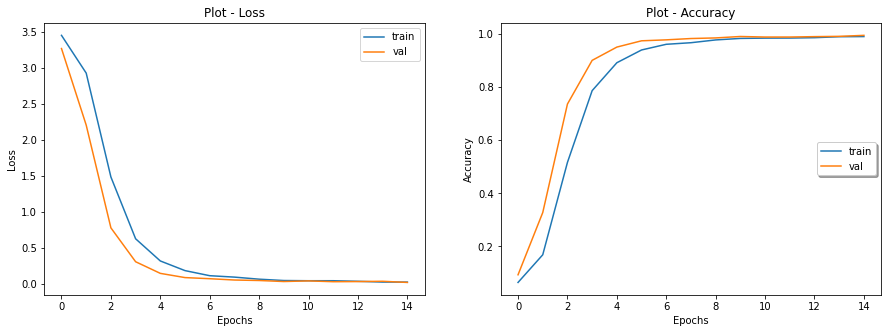

In [ ]:
# Plot loss and accuracies for training and validation data

_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)

# test using val_data

In [ ]:
# val_data.dataset

Dataset ImageFolder
    Number of datapoints: 26010
    Root location: ./Train
    StandardTransform
Transform: Compose(
               Resize(size=[112, 112], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
# # Load the saved model

# model = AlexnetTS(numClasses)
# model.load_state_dict(torch.load(PATH_TO_MODEL))
# model = model.cuda()

In [ ]:
# # Perform classification

# y_pred_list = []
# corr_classified = 0
# numExamples = len(val_data)

# ##
# labels_list = []

# with torch.no_grad():
#     model.eval()

#     # i = 0

#     for image, label_true in data.DataLoader(val_data, shuffle=True, batch_size = 1): # shuffle = False when test
#         labels_list.append(label_true.cpu().numpy()[0])
#         image = image.cuda()

#         y_test_pred = model(image)

#         y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
#         _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
#         y_pred_tags = y_pred_tags.cpu().numpy()

#         y_pred_list.append(y_pred_tags[0])
#         if label_true == y_pred_tags[0]:
#             corr_classified += 1

#         # i += 1

# print("Number of correctly classified images = %d" % corr_classified)
# print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
# print("Final accuracy = %f" % (corr_classified / numExamples))

Number of correctly classified images = 5179
Number of incorrectly classified images = 23
Final accuracy = 0.995579


In [ ]:
# # Print classification report

# print(classification_report(labels_list, y_pred_list))

In [ ]:
# Print confusion matrix

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
labels_arr = range(0, numClasses)
# plot_confusion_matrix(labels_list, y_pred_list, labels_arr)


# New Train

In [ ]:
# Initialize the model
# The model is defined in the class AlexnetTS in the file class_alexnetTS.py

model = AlexnetTS(numClasses)


# Define optimizer and criterion functions

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# If CUDA is available, convert model and loss to cuda variables

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
train_data_path = "./Train"
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)

train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)

In [ ]:
EPOCHS = 20

# Perform training

# List to save training and val loss and accuracies
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    
    # print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))

    print("")

Epoch-0: 
Training: Loss = 3.4520, Accuracy = 0.0629, Time = 29.30 seconds

Epoch-1: 
Training: Loss = 2.6210, Accuracy = 0.2223, Time = 29.01 seconds

Epoch-2: 
Training: Loss = 1.4166, Accuracy = 0.5190, Time = 28.94 seconds

Epoch-3: 
Training: Loss = 0.9478, Accuracy = 0.6740, Time = 29.33 seconds

Epoch-4: 
Training: Loss = 0.5290, Accuracy = 0.8140, Time = 30.53 seconds

Epoch-5: 
Training: Loss = 0.2631, Accuracy = 0.9107, Time = 30.26 seconds

Epoch-6: 
Training: Loss = 0.1631, Accuracy = 0.9435, Time = 29.10 seconds

Epoch-7: 
Training: Loss = 0.1008, Accuracy = 0.9654, Time = 29.19 seconds

Epoch-8: 
Training: Loss = 0.0748, Accuracy = 0.9749, Time = 29.04 seconds

Epoch-9: 
Training: Loss = 0.0570, Accuracy = 0.9814, Time = 29.82 seconds

Epoch-10: 
Training: Loss = 0.0537, Accuracy = 0.9819, Time = 29.51 seconds

Epoch-11: 
Training: Loss = 0.0363, Accuracy = 0.9881, Time = 29.01 seconds

Epoch-12: 
Training: Loss = 0.0401, Accuracy = 0.9866, Time = 28.96 seconds

Epoch-13:

Number of correctly classified images = 8147
Number of incorrectly classified images = 523
Final accuracy = 0.939677
              precision    recall  f1-score   support

           0       0.98      0.68      0.80        60
           1       0.93      0.98      0.95       420
           2       0.90      0.95      0.92       420
           3       0.97      0.99      0.98       420
           4       0.98      0.92      0.95       420
           5       0.90      0.94      0.92       420
           6       0.95      0.65      0.77        60
           7       0.97      0.96      0.97       420
           8       0.94      0.94      0.94       420
           9       0.99      1.00      1.00       420
          10       0.99      0.99      0.99       420
          11       0.97      0.96      0.96       420
          12       0.95      0.91      0.93       420
          13       0.97      0.99      0.98       420
          14       0.98      0.87      0.92       210
          15      

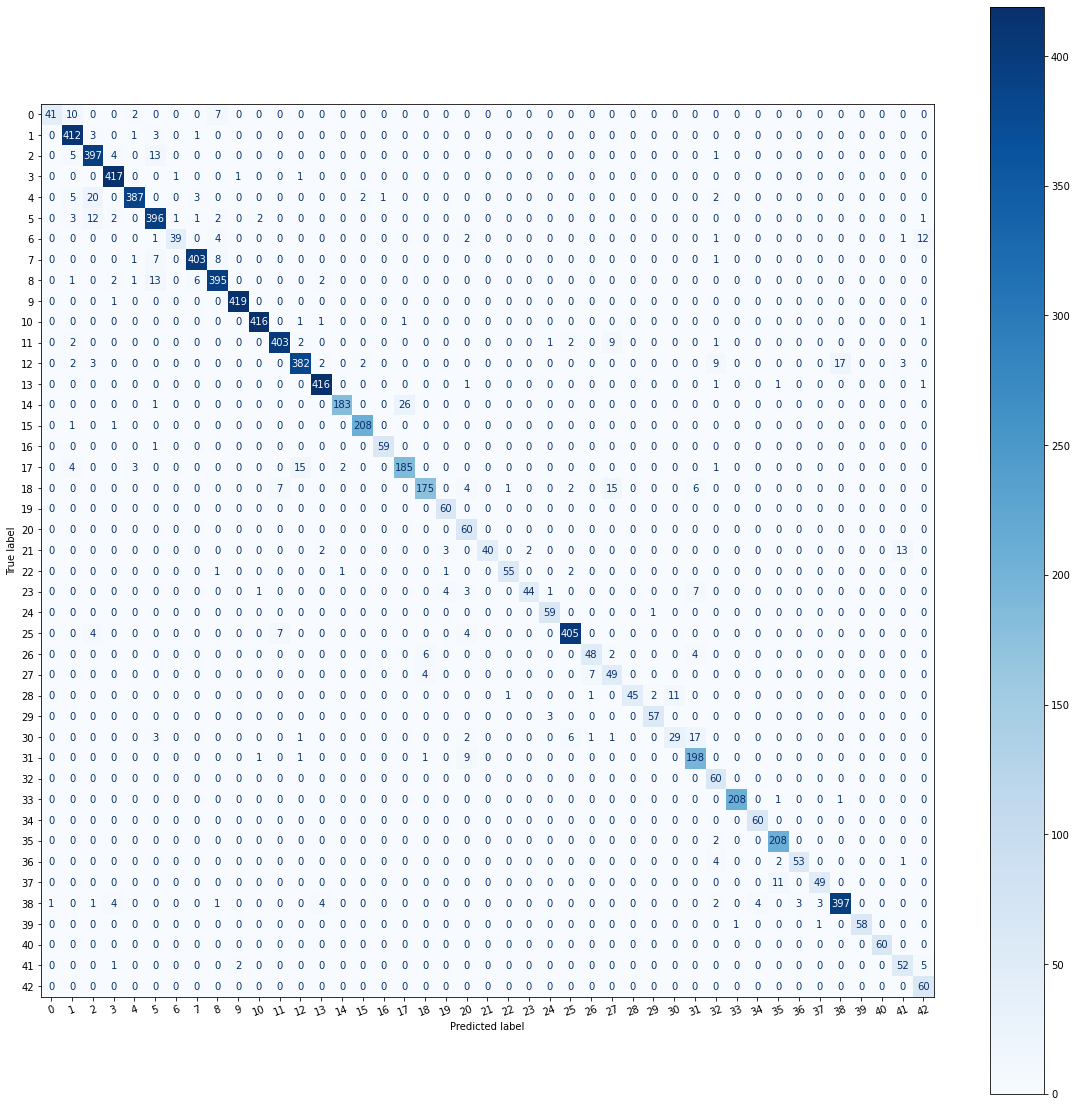

In [ ]:
test_answer = pd.read_csv('Test_Label.csv')
test_answer["pred_class"] = -1

num = range(numClasses)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])

# Perform classification
test_transforms = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
    ])
        
y_pred_list = []
corr_classified = 0
numExamples = len(test_answer)

##
labels_list = []

with torch.no_grad():
    model.eval()
    for f_name in test_answer["Filename"]:
        image = Image.open(f"Test//{f_name}")

        image = test_transforms(image)
        image = torch.unsqueeze(image, 0)
        image = image.cuda()

        y_test_pred = model(image)

        y_pred_softmax = torch.log_softmax(y_test_pred[0], dim=1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
        y_pred_tags = y_pred_tags.cpu().numpy()

        y_pred = y_pred_tags[0]
        y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)

        test_answer.loc[test_answer[test_answer["Filename"] == f_name].index, "pred_class"] = y_pred
        if test_answer[test_answer["Filename"] == f_name]["ClassId"].values[0] == y_pred:
            corr_classified += 1

        # i += 1

print("Number of correctly classified images = %d" % corr_classified)
print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
print("Final accuracy = %f" % (corr_classified / numExamples))

# Print classification report
print(classification_report(test_answer.ClassId, test_answer.pred_class))

plot_confusion_matrix(test_answer.ClassId, test_answer.pred_class, labels_arr)

# FINAL TEST